# Imports

In [2]:
!pip install geopandas
!pip install shapely
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [185]:
import geopandas as gpd
import shapefile as shp
import shapely
from shapely.geometry import Point
import cartopy.crs as ccrs
from cartopy.io.img_tiles import Stamen

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import seaborn as sns
import copy

In [4]:
sns.set_style('whitegrid')

In [37]:
!rm -r Data-Visualizations-Lab-3

In [38]:
!git clone https://github.com/Soumik-Roy/Data-Visualizations-Lab-3.git

Cloning into 'Data-Visualizations-Lab-3'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17 (delta 3), reused 15 (delta 1), pack-reused 0
Unpacking objects: 100% (17/17), 46.51 KiB | 5.81 MiB/s, done.


# Question 1 (Map of india with population bubbles)

## Map of india

<Axes: >

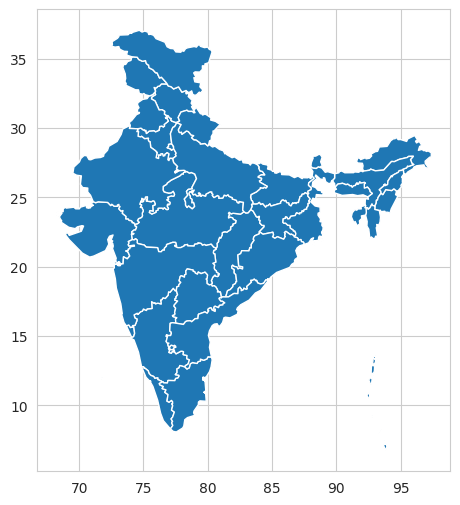

In [163]:
india_map = gpd.read_file('Data-Visualizations-Lab-3/india-polygon.shp')
india_data = copy.deepcopy(india_map)

# Plot the map
india_map.plot(figsize=(6, 6))

In [164]:
india_map.head()

,id,st_nm,geometry
0,NaN,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0..."
1,NaN,Arunachal Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612..."
2,NaN,Assam,"POLYGON ((95.19594 27.03612, 95.08795 26.94578..."
3,NaN,Bihar,"POLYGON ((88.11357 26.54028, 88.28006 26.37640..."
4,NaN,Chandigarh,"POLYGON ((76.84208 30.76124, 76.83758 30.72552..."


## Loading Data

#### State populations

Populations are in thousands i.e 381 means 381k or 3.81 lakhs

In [165]:
# Load the population data
pop_data = pd.read_csv('Data-Visualizations-Lab-3/india_states_data.csv', usecols = ['States_Union Territories','2011- POP'])
pop_data.columns = ['st_nm', 'population']
pop_data.head()

,st_nm,population
0,Andaman and Nicobar Islands,381
1,Andhra Pradesh,84581
2,Arunachal Pradesh,1384
3,Assam,31206
4,Bihar,104099


In [166]:
pop_data.shape

(32, 2)

In [167]:
india_data['population'] = 0

for row in pop_data.values:
    india_data.loc[india_data.loc[:, 'st_nm']==row[0], 'population'] = row[1]

#### State Capitals data

In [168]:
def normalString(text):
    return text.replace('ā', 'a')

In [169]:
cities = pd.read_csv(
    'Data-Visualizations-Lab-3/indian_cities.csv', 
    usecols = ['city','lat', 'lng', 'admin_name', 'capital', 'population_proper'],
)
cities = cities.loc[cities['capital']=='admin', :]
cities.drop(["capital"], axis=1, inplace=True)
cities.iloc[-2, 3] = 'Daman and Diu'
cities.loc[:, 'population_proper']/=1000
cities.head()

,city,lat,lng,admin_name,population_proper
0,Delhi,28.6600,77.2300,Delhi,16753.235
1,Mumbai,18.9667,72.8333,Mahārāshtra,12478.447
2,Kolkāta,22.5411,88.3378,West Bengal,4496.694
3,Bangalore,12.9699,77.5980,Karnātaka,8443.675
4,Chennai,13.0825,80.2750,Tamil Nādu,6727.000


In [170]:
cities.shape, india_data.shape

((32, 5), (37, 4))

In [171]:
list(cities.columns)

['city', 'lat', 'lng', 'admin_name', 'population_proper']

In [172]:
india_data['capital'] = india_data['st_nm']
india_data['cap_x'] = 0
india_data['cap_y'] = 0
india_data['cap_popln'] = india_data['population']

In [173]:
india_data.iloc[32, 2].centroid.x

87.96025594944172

In [174]:
for i in range(india_data.shape[0]):
    india_data.iloc[i, 5] = india_data.iloc[i, 2].centroid.x
    india_data.iloc[i, 6] = india_data.iloc[i, 2].centroid.y

In [175]:
for i, row in cities.iterrows():
    req_idx = india_data.loc[:, 'st_nm']==normalString(row['admin_name'])
    india_data.loc[req_idx, 'capital'] = row['city']
    india_data.loc[req_idx, 'cap_x'] = row['lng']
    india_data.loc[req_idx, 'cap_y'] = row['lat']
    india_data.loc[req_idx, 'cap_popln'] = row['population_proper']

## Adding population bubbles on the map 

In [176]:
india_data.head()

,id,st_nm,geometry,population,capital,cap_x,cap_y,cap_popln
0,NaN,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.84831 7.24028, 93.92705 7.0...",381,Port Blair,92.750000,11.666700,112.050
1,NaN,Arunachal Pradesh,"POLYGON ((95.23643 26.68105, 95.19594 27.03612...",1384,Itānagar,93.620000,27.100000,59.490
2,NaN,Assam,"POLYGON ((95.19594 27.03612, 95.08795 26.94578...",31206,Dispur,91.770000,26.150000,957.352
3,NaN,Bihar,"POLYGON ((88.11357 26.54028, 88.28006 26.37640...",104099,Patna,85.141400,25.610000,1684.222
4,NaN,Chandigarh,"POLYGON ((76.84208 30.76124, 76.83758 30.72552...",1055,Chandigarh,76.780629,30.733548,1055.000


#### State Population bubbles at State Centroid locations

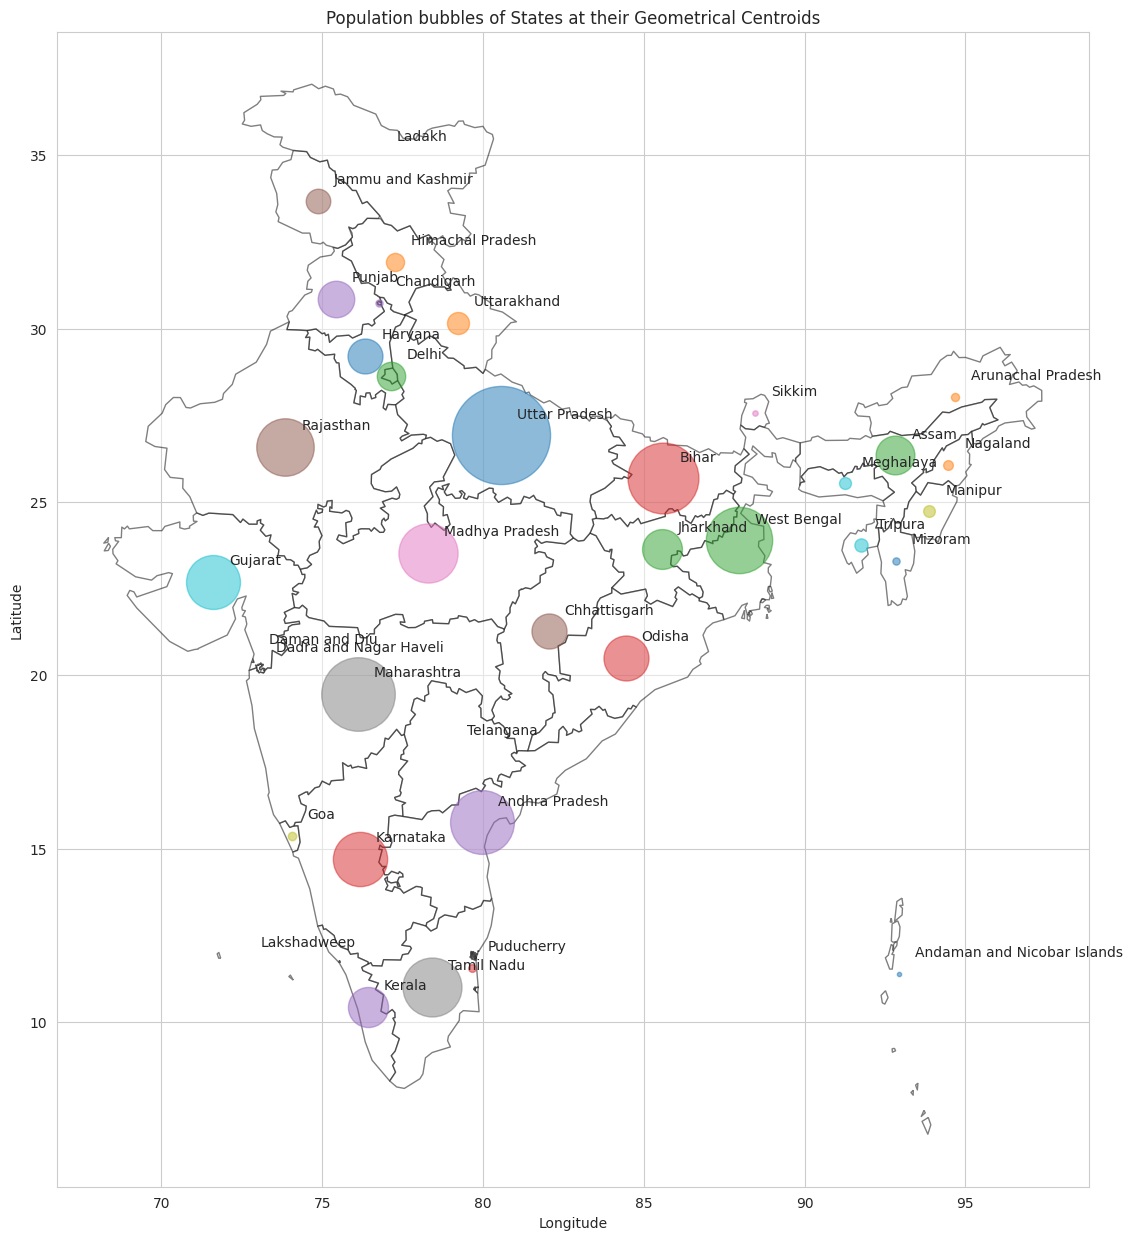

In [177]:
ig, ax = plt.subplots(figsize=(15,15))
india_map.plot(ax=ax, alpha=0.5, edgecolor='black', color='white')

# Create bubbles for each state capital
for i, row in india_data.iterrows():
    ax.scatter(row.geometry.centroid.x, row.geometry.centroid.y, s=row['population']/40, alpha=0.5)

# Add labels for state capitals
for i, row in india_data.iterrows():
    ax.annotate(
        row['st_nm'], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
        xytext=(row.geometry.centroid.x + 0.5, row.geometry.centroid.y + 0.5)
    )

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Population bubbles of States at their Geometrical Centroids")
plt.show()

#### State capital populations

Im taking `np.sqrt` to define size of bubbles, as the population represents area, but the parameter `s` in `plt.axis.scatter` represents radius of the bubbles. Hence taking square root of the population would adjust the dimensions to represent population properly.

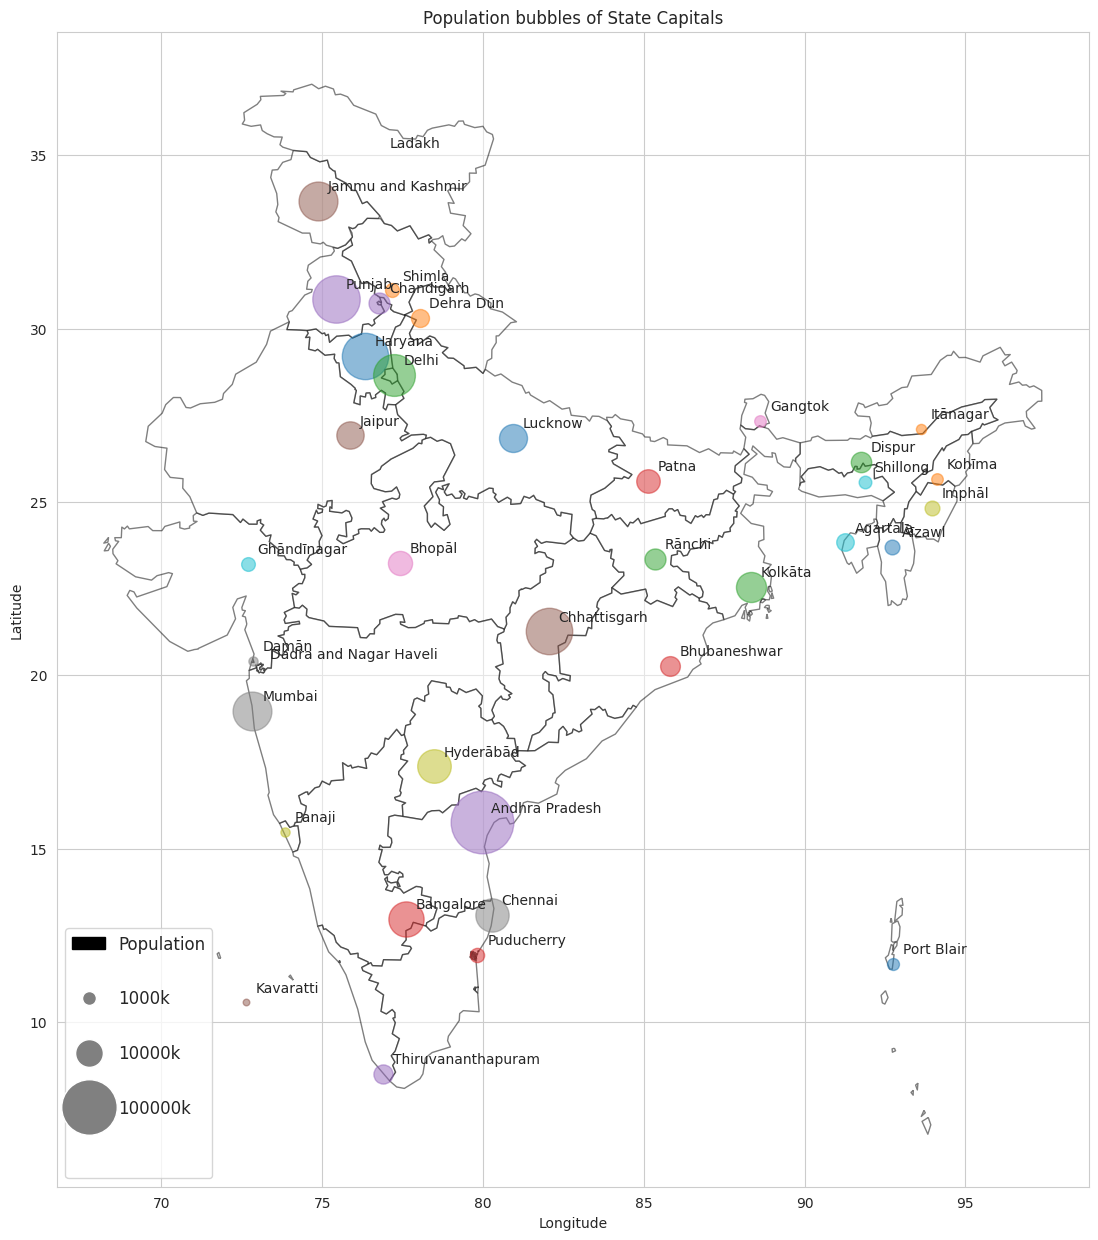

In [206]:
ig, ax = plt.subplots(figsize=(15,15))
india_map.plot(ax=ax, alpha=0.5, edgecolor='black', color='white')

# Create bubbles for each state capital
for i, row in india_data.iterrows():
    ax.scatter(row['cap_x'], row['cap_y'], s=np.sqrt(row['cap_popln'])*7, alpha=0.5)

# Add labels for state capitals
for i, row in india_data.iterrows():
    ax.annotate(
        row['capital'], 
        xy=(row['cap_x'], row['cap_y']), 
        xytext=(row['cap_x'] + 0.3, row['cap_y'] + 0.3)
    )

legend_elements = [Circle((0, 0), 1, color='black', label='Population'),
                   Line2D([0], [0], marker='o', color='w', label='1000k', markerfacecolor='grey', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='10000k', markerfacecolor='grey', markersize=20),
                   Line2D([0], [0], marker='o', color='w', label='100000k', markerfacecolor='grey', markersize=40),
                   Circle((0, 0), 0, color='white', label=''),
                   ]
ax.legend(handles=legend_elements, loc='lower left', fontsize=12, labelspacing=2.2)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title("Population bubbles of State Capitals")
plt.show()